# Figure 2a (Prisoner dilemma)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Evolution Engine

In [2]:
def get_payoff_and_coop(p, q, b1, b2, c, eps, mode='stochastic'):
    """
    Calculates long-term payoffs and cooperation rates for resident p vs mutant q.
    Solves an 8-state Markov chain: (Env1, CC, CD, DC, DD) and (Env2, CC, CD, DC, DD).
    """
    # Factor in execution error epsilon
    p_eff = p * (1 - 2 * eps) + eps
    q_eff = q * (1 - 2 * eps) + eps
    
    # 8x8 Transition Matrix M
    M = np.zeros((8, 8))
    opp_idx = {0: 0, 1: 2, 2: 1, 3: 3} # Maps opponent's memory-one indices
    
    for s in range(8):
        env_idx = s // 4
        c1 = p_eff[s]
        # Opponent's choice depends on the current environment and their perspective
        c2 = q_eff[env_idx * 4 + opp_idx[s % 4]]
        
        # Outcome probabilities: CC, CD, DC, DD
        probs = [c1 * c2, c1 * (1 - c2), (1 - c1) * c2, (1 - c1) * (1 - c2)]
        for act, prob in enumerate(probs):
            if mode == 'stochastic':
                # Core Mechanism: Only mutual cooperation (CC) returns to Game 1
                next_env = 0 if act == 0 else 1 
            elif mode == 'only_game1': 
                next_env = 0
            else: 
                next_env = 1
            
            M[s, next_env * 4 + act] = prob

    # Find the stationary distribution (eigenvector of eigenvalue 1)
    vals, vecs = np.linalg.eig(M.T)
    v = vecs[:, np.isclose(vals, 1.0)].real[:, 0]
    v /= v.sum()
    
    # Define payoff vectors for Game 1 and Game 2
    u1 = np.array([b1 - c, -c, b1, 0])
    u2 = np.array([b2 - c, -c, b2, 0])
    
    # Calculate resident payoff
    pi_p = np.dot(v[:4], u1) + np.dot(v[4:], u2)
    
    # Calculate mutant payoff (swap CD/DC payoffs for the mutant's perspective)
    u1_m = np.array([b1 - c, b1, -c, 0])
    u2_m = np.array([b2 - c, b2, -c, 0])
    pi_q = np.dot(v[:4], u1_m) + np.dot(v[4:], u2_m)
    
    # Return resident payoff, mutant payoff, and resident cooperation rate
    return pi_p, pi_q, np.dot(v, p_eff)

def get_fixation_probability(pi_m, pi_r, pi_mm, pi_rm, n_pop, beta):
    """
    Calculates the exact fixation probability in a finite population.
    pi_m: mutant vs resident payoff
    pi_r: resident vs resident payoff
    pi_mm: mutant vs mutant payoff
    pi_rm: resident vs mutant payoff
    """
    diffs = []
    for j in range(1, n_pop):
        # f_m: mutant fitness at frequency j/N
        f_m = ((j - 1) * pi_mm + (n_pop - j) * pi_m) / (n_pop - 1)
        # f_r: resident fitness at frequency (N-j)/N
        f_r = (j * pi_rm + (n_pop - j - 1) * pi_r) / (n_pop - 1)
        diffs.append(f_r - f_m)
    
    # Sum of selection differences for the fixation probability formula
    exponent_sums = np.cumsum(beta * np.array(diffs))
    return 1.0 / (1.0 + np.sum(np.exp(np.clip(exponent_sums, -500, 500))))

## Simulation

In [3]:
def run_trajectory(mode):
    """Simulates evolutionary dynamics for a specific game mode."""
    print(f"Simulating mode: {mode}...")
    combined_history = np.zeros(STEPS)
    
    for run in range(RUNS):
        # Start with a population of All-Defectors (Memory-1 strategy: 00000000)
        res_strat = np.zeros(8) 
        curr_coop = 0
        
        for t in range(STEPS):
            combined_history[t] += curr_coop
            # Generate a random Memory-1 mutant strategy
            mut_strat = np.random.randint(0, 2, 8)
            
            # 1. Get resident payoff against itself
            pi_rr, _, _ = get_payoff_and_coop(res_strat, res_strat, B1, B2, C, EPS, mode)
            
            # 2. Get resident vs mutant and mutant vs resident payoffs
            pi_rm, pi_mr, _ = get_payoff_and_coop(res_strat, mut_strat, B1, B2, C, EPS, mode)
            
            # 3. Get mutant payoff against itself
            pi_mm, _, _ = get_payoff_and_coop(mut_strat, mut_strat, B1, B2, C, EPS, mode)
            
            # Fixation: Determine if the mutant takes over the population
            # Args: (mut_vs_res, res_vs_res, mut_vs_mut, res_vs_mut)
            p_fix = get_fixation_probability(pi_mr, pi_rr, pi_mm, pi_rm, N, BETA)
            
            if np.random.rand() < p_fix:
                res_strat = mut_strat
                _, _, curr_coop = get_payoff_and_coop(res_strat, res_strat, B1, B2, C, EPS, mode)
                
    return combined_history / RUNS

### Parameters

In [4]:
# --- 1. PD Core Parameters  ---
B1, B2, C = 2.0, 1.2, 1.0  # Benefit and cost
N = 100                    # Population size
BETA = 1.0                 # Selection intensity
EPS = 0.001                # Execution error
STEPS = 5000               # Time steps (number of mutants)
RUNS = 100                 # Number of independent simulations to average

### Execution

In [5]:
stochastic = run_trajectory('stochastic')
game1 = run_trajectory('only_game1')
game2 = run_trajectory('only_game2')

Simulating mode: stochastic...
Simulating mode: only_game1...
Simulating mode: only_game2...


### Results plot

Saved: figure_2a.pdf
Saved: figure_2a.png


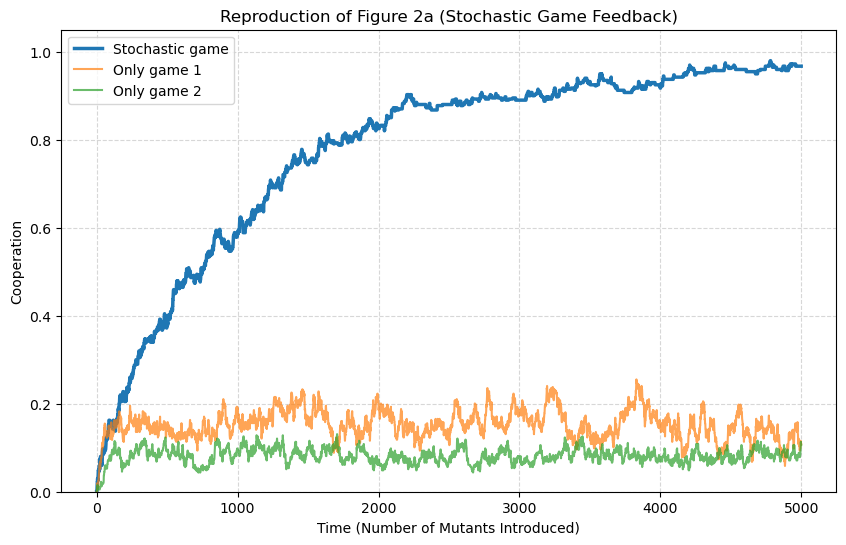

In [7]:
def save_figure(filename, formats=['pdf'], **kwargs):
    """
    Save current figure in multiple formats.
    
    Parameters:
    - filename: Base filename without extension
    - formats: List of formats ['pdf', 'png', 'svg', 'jpg', etc.]
    - **kwargs: Additional kwargs for plt.savefig()
    """
    for fmt in formats:
        full_name = f"{filename}.{fmt}"
        plt.savefig(full_name, format=fmt, bbox_inches='tight', **kwargs)
        print(f"Saved: {full_name}")

plt.figure(figsize=(10, 6))
plt.plot(stochastic, label='Stochastic game', linewidth=2.5)
plt.plot(game1, label='Only game 1', alpha=0.7)
plt.plot(game2, label='Only game 2', alpha=0.7)

plt.ylim(0, 1.05)
plt.xlabel('Time (Number of Mutants Introduced)')
plt.ylabel('Cooperation')
plt.title('Reproduction of Figure 2a (Stochastic Game Feedback)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

save_figure('figure_2a', formats=['pdf', 'png'], dpi=300)
plt.show()